In [16]:
# Célula 1
from pathlib import Path
import math, json, random, time
from dataclasses import dataclass
from typing import Dict, List, Tuple

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from PIL import Image

random.seed(42)
np.random.seed(42)


Tamanho da imagem: 1434x830px


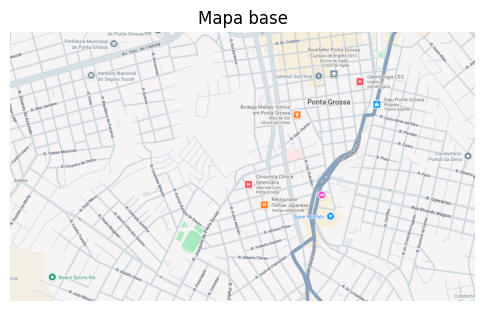

In [17]:
# Célula 2
IMAGE_PATH = "/content/Captura de tela 2025-09-17 112504.png"  # troque aqui se quiser

def load_image(image_path: str) -> Image.Image:
    p = Path(image_path)
    if not p.exists():
        try:
            from google.colab import files  # só existe no Colab
            print("Arquivo não encontrado. Faça upload do seu mapa...")
            uploaded = files.upload()
            fname = next(iter(uploaded.keys()))
            return Image.open(fname).convert("RGB")
        except Exception as e:
            raise FileNotFoundError(f"Não achei {image_path} e o upload falhou: {e}")
    return Image.open(image_path).convert("RGB")

img = load_image(IMAGE_PATH)
W, H = img.size
print(f"Tamanho da imagem: {W}x{H}px")

plt.figure(figsize=(6,5))
plt.imshow(img); plt.axis('off'); plt.title("Mapa base")
plt.show()


In [18]:
# Célula 3
PIX_POINTS: Dict[str, Tuple[int, int]] = {
    "supermuffato":       (988, 579),
    "institutonacional":  (247, 150),
    "beach sports":       (130, 5770),   # fora da imagem? será clipado
    "catedral santana":   (949, 152),
    "clineponta":         (730, 472),
    "pontaldaserra":      (1413, 398),
    "bodegamalbec":       (884, 261),
    "daju":               (1135, 235),
    "ronda":              (34, 162),
    "odonto":             (1075, 162),
}

warnings = []

def norm_point(xy: Tuple[int,int]) -> Tuple[float,float]:
    x, y = xy
    x2 = max(0, min(x, W-1))
    y2 = max(0, min(y, H-1))
    if (x, y) != (x2, y2):
        warnings.append(f"Coordenada ({x},{y}) fora da imagem -> clip para ({x2},{y2})")
    # normaliza p/ [0,1] e inverte Y (origem de imagem é topo)
    xn = x2 / (W-1)
    yn = 1.0 - (y2 / (H-1))
    return (xn, yn)

LOCATIONS: Dict[str, Tuple[float,float]] = {k: norm_point(v) for k, v in PIX_POINTS.items()}

print("Pontos normalizados [0,1]:")
for k, v in LOCATIONS.items():
    print(f" - {k:>18s}: {v}")
if warnings:
    print("\nAvisos:")
    for w in warnings:
        print(" -", w)


Pontos normalizados [0,1]:
 -       supermuffato: (0.6894626657362177, 0.3015681544028951)
 -  institutonacional: (0.17236566643405443, 0.8190591073582629)
 -       beach sports: (0.09071877180739707, 0.0)
 -   catedral santana: (0.6622470341939986, 0.8166465621230399)
 -         clineponta: (0.5094207955338451, 0.4306393244873341)
 -      pontaldaserra: (0.9860432658757851, 0.519903498190591)
 -       bodegamalbec: (0.6168876482903001, 0.6851628468033776)
 -               daju: (0.7920446615491975, 0.7165259348612787)
 -              ronda: (0.02372644801116539, 0.804583835946924)
 -             odonto: (0.7501744591765527, 0.804583835946924)

Avisos:
 - Coordenada (130,5770) fora da imagem -> clip para (130,829)


In [19]:
# Célula 4
def build_distance_matrix(points: List[Tuple[float, float]]) -> np.ndarray:
    pts = np.array(points)  # (N,2)
    diff = pts[:, None, :] - pts[None, :, :]
    dist = np.sqrt((diff ** 2).sum(axis=-1))
    np.fill_diagonal(dist, np.inf)
    return dist

def route_length(path: List[int], D: np.ndarray) -> float:
    return sum(D[path[i], path[(i + 1) % len(path)]] for i in range(len(path)))

def plot_solution_over_map(
    image: np.ndarray,
    locs: Dict[str, Tuple[float,float]],
    best_idx: List[int],
    title: str,
    out_path: str = None
):
    labels = list(locs.keys())
    coords = np.array(list(locs.values()))
    fig, ax = plt.subplots(figsize=(8,6))
    ax.imshow(image, extent=(0,1,0,1))
    ax.set_xticks([]); ax.set_yticks([]); ax.set_title(title)

    ax.scatter(coords[:,0], coords[:,1], s=60, zorder=3)
    for i,lab in enumerate(labels):
        ax.text(coords[i,0]+0.004, coords[i,1]+0.004, lab, fontsize=9)

    path_coords = coords[best_idx + [best_idx[0]]]
    ax.plot(path_coords[:,0], path_coords[:,1], linewidth=2, zorder=2)

    plt.show()
    if out_path:
        fig.savefig(out_path, dpi=150, bbox_inches="tight")
        plt.close(fig)


In [20]:
# Célula 5
@dataclass
class ACOParams:
    n_iterations:int = 150
    ant_count:int    = 20
    min_ants:int     = 10
    decay:float      = 0.5            # evaporação (0..1)
    pheromone_power:float = 1.0       # α
    distance_power:float  = 3.0       # β
    seed:int = 42

class AntColonyTSP:
    def __init__(self, D: np.ndarray, params: ACOParams):
        self.D = D.astype(float); self.N = D.shape[0]; self.p = params
        random.seed(self.p.seed); np.random.seed(self.p.seed)
        self.tau = np.full_like(D, 1e-3, dtype=float); np.fill_diagonal(self.tau, 0.0)
        eta = 1.0 / D; eta[D==np.inf]=0.0; self.eta_beta = eta ** self.p.distance_power

    def _pick_next(self, cur:int, allowed:List[int])->int:
        tau_a = self.tau[cur, allowed] ** self.p.pheromone_power
        eta_b = self.eta_beta[cur, allowed]
        desir = tau_a * eta_b
        if desir.sum()==0: return int(np.random.choice(allowed))
        probs = desir/desir.sum(); return int(np.random.choice(allowed, p=probs))

    def _build_solution(self)->List[int]:
        start = np.random.randint(self.N)
        tour=[start]; allowed=set(range(self.N))-{start}; cur=start
        while allowed:
            nxt = self._pick_next(cur, list(allowed))
            tour.append(nxt); allowed.remove(nxt); cur=nxt
        return tour

    def _evap(self): self.tau *= (1.0 - self.p.decay)

    def _deposit(self, tours:List[List[int]]):
        for t in tours:
            L = route_length(t, self.D)
            if not np.isfinite(L) or L<=0: continue
            dep = 1.0/L
            for i in range(self.N):
                a=t[i]; b=t[(i+1)%self.N]; self.tau[a,b]+=dep; self.tau[b,a]+=dep

    def run(self):
        best=None; bestL=float("inf"); n_ants=max(self.p.ant_count, self.p.min_ants)
        for _ in range(self.p.n_iterations):
            tours=[self._build_solution() for _ in range(n_ants)]
            for t in tours:
                L=route_length(t,self.D)
                if L<bestL: bestL=L; best=t
            self._evap(); self._deposit(tours)
        return best, bestL


baseline: L=3.213 | rota = bodegamalbec → catedral santana → odonto → daju → pontaldaserra → supermuffato → clineponta → beach sports → ronda → institutonacional


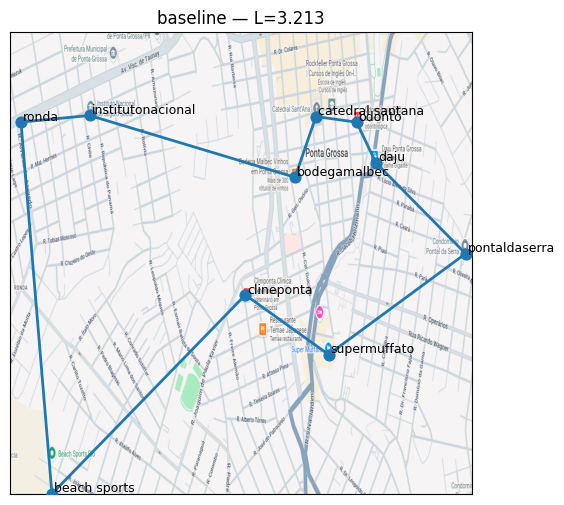

var_distance_power_1.0: L=3.213 | rota = clineponta → supermuffato → pontaldaserra → daju → odonto → catedral santana → bodegamalbec → institutonacional → ronda → beach sports


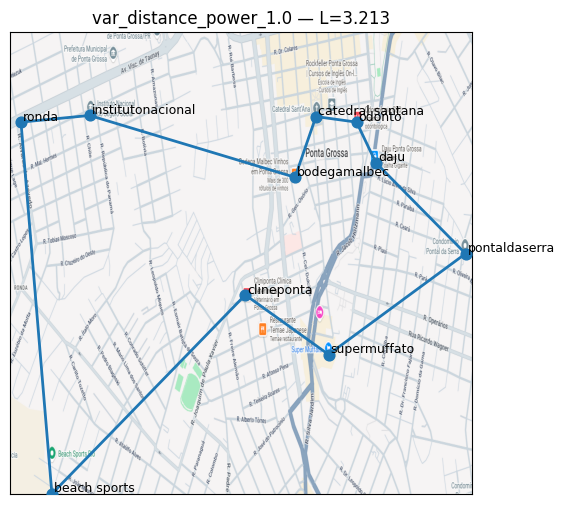

var_pheromone_power_2.0: L=3.213 | rota = bodegamalbec → catedral santana → odonto → daju → pontaldaserra → supermuffato → clineponta → beach sports → ronda → institutonacional


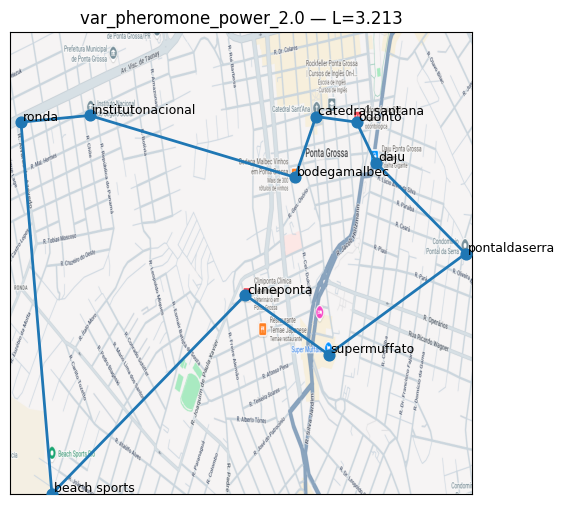


Arquivos salvos em /content: baseline.png, var_distance_power_1.0.png, var_pheromone_power_2.0.png

Avisos de clipping:
 - Coordenada (130,5770) fora da imagem -> clip para (130,829)


In [21]:
# Célula 6
labels = list(LOCATIONS.keys())
coords = [LOCATIONS[k] for k in labels]
D = build_distance_matrix(coords)
img_np = np.asarray(img)

def run_once(name: str, params: dict):
    aco = AntColonyTSP(D, ACOParams(**params))
    best_idx, bestL = aco.run()
    best_labels = [labels[i] for i in best_idx]
    print(f"{name}: L={bestL:.3f} | rota = {' → '.join(best_labels)}")
    plot_solution_over_map(img_np, LOCATIONS, best_idx, f"{name} — L={bestL:.3f}",
                           out_path=f"/content/{name}.png")
    return {"name":name, "bestL":bestL, "best_idx":best_idx, "best_labels":best_labels, "params":params}

BASE = dict(n_iterations=150, ant_count=20, min_ants=10, decay=0.5,
            pheromone_power=1.0, distance_power=3.0, seed=42)
RES_BASE = run_once("baseline", BASE)

# Q2: altere UM parâmetro (ex.: distance_power)
RES_Q2   = run_once("var_distance_power_1.0", dict(BASE, distance_power=1.0))

# Q3: altere OUTRO parâmetro diferente (ex.: pheromone_power)
RES_Q3   = run_once("var_pheromone_power_2.0", dict(BASE, pheromone_power=2.0))

print("\nArquivos salvos em /content: baseline.png, var_distance_power_1.0.png, var_pheromone_power_2.0.png")
if warnings:
    print("\nAvisos de clipping:")
    for w in warnings:
        print(" -", w)


In [22]:
# Célula 7
pdf_path = "/content/atividade_enxame_relatorio.pdf"

def add_page(pdf, res, comment):
    fig = plt.figure(figsize=(8.27, 11.69))  # A4 portrait
    ax = fig.add_axes([0.07, 0.72, 0.86, 0.25]); ax.axis("off")
    txt = (
        f"{res['name']}\n\n"
        f"Parâmetros: {json.dumps(res['params'])}\n"
        f"Melhor L: {res['bestL']:.3f}\n"
        f"Rota: {' → '.join(res['best_labels'])}\n\n"
        f"Comentário: {comment}\n"
    )
    ax.text(0.0, 1.0, txt, va="top", wrap=True)

    ax2 = fig.add_axes([0.07, 0.05, 0.86, 0.62])
    ax2.imshow(Image.open(f"/content/{res['name']}.png")); ax2.axis("off")
    pdf.savefig(fig); plt.close(fig)

with PdfPages(pdf_path) as pdf:
    # capa
    fig, ax = plt.subplots(figsize=(8.27, 11.69)); ax.axis("off")
    cap = (f"Atividade Somativa — ACO para TSP\n\n"
           f"Mapa: {Path(IMAGE_PATH).name}\nDimensões: {W}x{H}px\n"
           f"Pontos: {len(LOCATIONS)}\n")
    if warnings:
        cap += "\nAvisos:\n- " + "\n- ".join(warnings)
    ax.text(0.05, 0.95, cap, va="top", wrap=True)
    pdf.savefig(fig); plt.close(fig)

    add_page(pdf, RES_BASE, "Baseline para comparação.")
    add_page(pdf, RES_Q2,   "Q2 — distance_power menor (β↓) → mais exploração; rota pode piorar.")
    add_page(pdf, RES_Q3,   "Q3 — pheromone_power maior (α↑) → segue trilhas fortes; converge rápido, mas arrisca ótimo local.")

print(f"PDF gerado em: {pdf_path}")


PDF gerado em: /content/atividade_enxame_relatorio.pdf
